In [1]:
using Pkg 
Pkg.activate(".")
Pkg.instantiate()
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
SHOW_PROGRESS_BAR = true

  Activating project at `~/Documents/GIC-quAI-QRC/qrc_mnist_julia`


true

In [2]:
using MLDatasets
using MultivariateStats
using OneHotArrays
using Flux
using Bloqade
using Colors
using ProgressBars
using JLD2
using Plots
using ImageShow

    CondaPkg Found dependencies: /home/nuno/.julia/packages/Bloqade/mMzgS/CondaPkg.toml
    CondaPkg Found dependencies: /home/nuno/.julia/packages/PythonCall/WMWY0/CondaPkg.toml
    CondaPkg Found dependencies: /home/nuno/.julia/packages/PythonPlot/oS8x4/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /home/nuno/.julia/artifacts/cefba4912c2b400756d043a2563ef77a0088866b/bin/pixi
             │ init
             │ --format pixi
             └ /home/nuno/Documents/GIC-quAI-QRC/qrc_mnist_julia/.CondaPkg
✔ Created /home/nuno/Documents/GIC-quAI-QRC/qrc_mnist_julia/.CondaPkg/pixi.toml
    CondaPkg Wrote /home/nuno/Documents/GIC-quAI-QRC/qrc_mnist_julia/.CondaPkg/pixi.toml
             │ [dependencies]
             │ openssl = ">=1.1, <1.1.24"
             │ libstdcxx-ng = ">=3.4,<13.0"
             │ matplotlib = "3.5.1, >=1"
             │ 
             │     [dependencies.python]
             │     channel = "conda-forge"
             │     build = "*cpython*"
             │   

# Load the Generated Polyp Dataset

In [3]:
# 6e5 28x28 images
data_train = MNIST(split=:train)

# 1e5 28x28 images
data_test = MNIST(split=:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

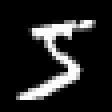

In [4]:
convert2image(data_train, 1)

# PCA Reduction

In [5]:
#=
The data_train and data_test are currently in the form 28x28x1x60000 and 28x28x1x10000 respectively.

We need to flatten the images in order to use them in the PCA algorithm.
The images are 28x28 pixels, and we need to convert them to a 784-dimensional vector (28*28=784).
=#

dataset_length = size(data_train)[1]

image_dim = size(data_train[1].features)
image_size = image_dim[1] * image_dim[2]

# Flattened images
data_train_flat = reshape(data_train.features, (image_size, dataset_length))

# Number of principal components
dim_pca = 8

# The 'fit' function from the 'MultivariateStats' package generates the projection operator for the PCA
model_pca = fit(PCA, data_train_flat, maxoutdim=dim_pca)

# Compute the first 8 principal components
x = predict(model_pca, data_train_flat)

num_examples = 10_000
xs = x[:, 1:num_examples]

8×10000 Matrix{Float32}:
  0.485966    3.96748   -0.203378   …  -1.89963   -1.48374   -1.45349
 -1.22618    -1.15631    1.53793       -1.36298    1.87735    2.20833
  0.0961575  -2.33856    0.739268      -3.06433    1.69584   -2.16987
 -2.1794     -1.80688    2.04323        0.457865  -1.00216   -1.84321
 -0.107123   -3.2443    -1.20274        1.86214    1.05195   -1.40482
 -0.911681   -0.713546  -0.0072065  …  -1.30817   -0.316313   0.778604
 -0.91759     0.17659    3.36885       -0.899219   1.00496   -1.32523
  0.626681   -0.411637   1.44547        1.52077   -0.671546   0.0921286

In [6]:
#= 
We need to scale the range of the principal components to a range of local detuning (-6rad/μs, 6rad/μs).

Later, for each image, we will encode each of the 8 scaled principal components into each single local detuning for 8 atoms
=# 

Δ_max = 6.0
spectral = max(abs(maximum(xs)), abs(minimum(xs)))
xs = xs/spectral * Δ_max

8×10000 Matrix{Float64}:
  0.319298    2.60678   -0.133627    …  -1.24813   -0.97487   -0.955
 -0.805644   -0.759738   1.01048        -0.895528   1.23349    1.45096
  0.0631791  -1.53652    0.485726       -2.01338    1.11423   -1.42568
 -1.43195    -1.18719    1.34248         0.300835  -0.658459  -1.21106
 -0.0703837  -2.13162   -0.790246        1.2235     0.69117   -0.923017
 -0.599009   -0.468826  -0.00473494  …  -0.859518  -0.20783    0.511572
 -0.602891    0.116026   2.21346        -0.59082    0.660294  -0.870723
  0.411753   -0.270461   0.949727        0.999201  -0.441231   0.0605319

In [7]:
#=
One-hot encoding turns the labels into a binary matrix representation, 
for example, the labels 0 through 9 are converted into 10-dimensional binary vectors.
0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
...
9 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

This is useful for some machine learning algorithms
=#

y = onehotbatch(data_train.targets, 0:9)
ys = y[:, 1:num_examples]


10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅

# Simulate Quantum Dynamics

In [8]:
Base.@kwdef struct DetuningLayer
    atoms # atom positions 
    readouts # readout observables
    Ω::Float64 # Rabi frequency
    t_start::Float64 # evolution starting time
    t_end::Float64 # evolution ending time
    step::Float64 # readout time step
    reg::AbstractArrayReg # quantum state storage
end

DetuningLayer

In [9]:
function apply_layer(layer::DetuningLayer, x::Vector{<:Real})
    # define Rydberg hamiltonian, detunings parametrized in termos of PCA values (x)
    h = rydberg_h(layer.atoms; Δ=x, Ω=layer.Ω)

    # at the start of the simulation, all atoms are in the ground state
    reg = layer.reg
    set_zero_state!(reg)

    t_start = layer.t_start
    t_end = layer.t_end
    t_step = layer.step

    # initialize output vector
    steps = floor(Int, (t_end - t_start) / t_step)
    out = zeros(steps * length(layer.readouts))


    # numerically simulate quantum evolution with Krylov methods and store the readouts
    prob = KrylovEvolution(
        reg, 
        layer.t_start:layer.step:layer.t_end, 
        h
    )   
     
    i = 1 
    for (step, reg, _) in prob # check the states at every time step
        step == 1 && continue # ignore initial state step

        for op in layer.readouts
            out[i] = real(expect(op, reg)) # store the expectation value of each operator for the given state at the current time step
            i += 1
        end
    end
    return out
end


# apply "DetuningLayer" to a matrix containin scaled detunings for each image
function apply_layer(layer::DetuningLayer, x::Matrix{<:Real})
    iter = 1:size(x, 2)
    if SHOW_PROGRESS_BAR
        iter = ProgressBar(1:size(x, 2))
    end

    outs = [apply_layer(layer, x[:, i]) for i in iter]
    return hcat(outs...)
end

apply_layer (generic function with 2 methods)

In [10]:
#=
Prepare the 8 atom chain lattice
=# 

d = 10
atoms = generate_sites(
    ChainLattice(),
    dim_pca;
    scale=d
)

# All single site Z_i and correlator Z_iZ_j readouts
nsites = length(atoms)
readouts = AbstractBlock[put(nsites, i => Z) for i in 1:nsites]
for i in 1:nsites
    for j in i+1:nsites
        push!(readouts, chain(put(nsites, i => Z), put(nsites, j => Z)))
    end
end

# build pre_processing layer - we decide to run the dynamics for 4μs, sampling every 0.5μs
pre_layer = DetuningLayer(;
    atoms,
    readouts,
    Ω=2π,
    t_start=0.0,
    t_end=4.0,
    step=0.5,
    reg=zero_state(nsites)
);

In [11]:
#=
Run the simulation by applying pre_layer to the scaled detunings for each image.

The readouts from the quantum dynamics will form a 288-dimensional vector.

The full results will be stored in a 288×1_000 matrix 'embeddings'
=#

embeddings = apply_layer(pre_layer, xs)

0.0%┣                                           ┫ 0/10.0k [00:00<-1:-29, -0s/it]
0.0%┣                                        ┫ 1/10.0k [00:18<Inf:Inf, InfGs/it]
0.0%┣                                          ┫ 3/10.0k [00:18<24:34:13, 9s/it]
0.1%┣                                          ┫ 7/10.0k [00:18<08:12:50, 3s/it]
0.1%┣                                         ┫ 10/10.0k [00:18<05:30:28, 2s/it]
0.1%┣                                         ┫ 13/10.0k [00:18<04:08:33, 1s/it]
0.2%┣                                         ┫ 16/10.0k [00:18<03:19:26, 1s/it]
0.2%┣                                         ┫ 18/10.0k [00:18<02:56:42, 1s/it]
0.2%┣                                         ┫ 21/10.0k [00:18<02:30:38, 1it/s]
0.2%┣                                         ┫ 24/10.0k [00:18<02:11:21, 1it/s]
0.3%┣                                         ┫ 27/10.0k [00:18<01:56:36, 1it/s]
0.3%┣▏                                        ┫ 30/10.0k [00:18<01:44:51, 2it/s]
0.3%┣▏                      

288×10000 Matrix{Float64}:
 -0.617909     -0.768707    …  -0.327112   -0.333077   -0.3323
  0.179948      0.115031        0.132634   -0.181257   -0.267368
 -0.0752524     0.238952        0.344111   -0.201917    0.246344
  0.256691      0.124107       -0.0946384   0.13882     0.164447
 -0.0419238     0.35154        -0.233681   -0.151672    0.149628
  0.0912827     0.0269982   …   0.1542      0.0533878  -0.142066
  0.132094      0.00382744      0.121978   -0.0945814   0.195272
 -0.625446     -0.496815       -0.696723   -0.452521   -0.580871
 -0.287888     -0.08116        -0.305948   -0.0741465   0.00258912
  0.185452     -0.252945        0.117       0.242812    0.13778
  ⋮                         ⋱                          
  0.155115     -0.0569168      -0.0314684   0.118778   -0.0057701
 -0.0704208     0.125869    …  -0.101844   -0.0984672  -0.0139802
  0.000236666   0.037903        0.0375237  -0.0838437   0.0994145
 -0.125416      0.176949       -0.0189571   0.0724883  -0.159363
 -0.0

# Classical Training

In [12]:
# function to evaluate the accuracy by comparing the predicted labels with the true labels.
accuracy(model, xs, targets) = sum(onecold(model(xs), 0:9) .== targets) / length(targets)

# function to take the training and test features and labels as well as the training hyperparameters
function train(
    xs_train, ys_train, xs_test, ys_test;
    regularization::Float64 = 0.0, 
    nepochs::Int = 100,
    batchsize::Int = 100,
    opt = Flux.Adam(0.01),
    verbose::Bool, 
    nonlinear::Bool = false
    )

    # linear regression pre_layer
    model = Chain(
        Dense(length(xs_train[:, 1]), 10),
        softmax
    )

    # 4-layer neural network for comparison with QRC
    if nonlinear
        model = Chain(
            Dense(length(xs_train[:, 1]), 100, relu),
            Dense(100, 100, relu),
            Dense(100, 10),
            softmax
        )
    end

    # Load the training data into a DataLoader for efficient batch processing
    loader = Flux.DataLoader(
        (data = xs_train, label = ys_train);
        batchsize,
        shuffle = true
    );

    ps = Flux.params(model)

    verbose && println("Training...")
    losses = zeros(nepochs)
    accs_train = zeros(nepochs)
    accs_test = zeros(nepochs)

    # Training loop
    for epoch in (verbose ? ProgressBar(1:nepochs) : 1:nepochs)
        l = 1.0

        # For each batch of data, compute the gradients and update the model parameters
        for (x, y) in loader
            # Compute the gradients
            grads = Flux.gradient(ps) do 
                # Compute the model output
                ŷ = model(x)

                # If regularization is not zero, add it to the loss
                # The loss function is the cross-entropy loss
                if iszero(regularization)
                    l = Flux.crossentropy(ŷ, y)
                else
                    l = Flux.crossentropy(ŷ, y) + regularization * sum(sum(abs, p) for p in ps)
                end
                
            end
            # Update the model parameters using the computed gradients
            Flux.update!(opt, ps, grads)
        end

        # Compute the loss and accuracy on the training and test sets
        losses[epoch] = Flux.crossentropy(model(xs_train), ys_train)
        accs_train[epoch] = accuracy(model, xs_train, onecold(ys_train, 0:9))
        accs_test[epoch] = accuracy(model, xs_test, ys_test)
    end

    return losses, accs_train, accs_test
end

train (generic function with 1 method)

In [13]:
#=

Evaluate the model

=# 

num_test_examples = 1_000

# use the same PCA model as before to fit the test data
test_features = predict(model_pca, reshape(data_test.features, (image_size, size(data_test)[1])))[:, 1:num_test_examples]

# scale to the detuning range 
test_features_qrc = test_features/spectral * Δ_max

# correct labels for the test samples
test_targets = data_test.targets[1:num_test_examples]

# quantum embeddings for the test samples
test_embeddings = apply_layer(pre_layer, test_features_qrc)

0.0%┣                                             ┫ 0/1.0k [00:00<00:00, -0s/it]
0.5%┣▎                                            ┫ 5/1.0k [00:00<00:14, 74it/s]
0.9%┣▍                                            ┫ 9/1.0k [00:00<00:14, 69it/s]
1.3%┣▋                                           ┫ 13/1.0k [00:00<00:14, 72it/s]
1.6%┣▊                                           ┫ 16/1.0k [00:00<00:14, 68it/s]
2.0%┣▉                                           ┫ 20/1.0k [00:00<00:14, 70it/s]
2.4%┣█                                           ┫ 24/1.0k [00:00<00:14, 68it/s]
2.8%┣█▎                                          ┫ 28/1.0k [00:00<00:14, 69it/s]
3.2%┣█▍                                          ┫ 32/1.0k [00:00<00:14, 68it/s]
3.4%┣█▌                                          ┫ 34/1.0k [00:01<00:15, 65it/s]
3.7%┣█▋                                          ┫ 37/1.0k [00:01<00:15, 63it/s]
3.9%┣█▊                                          ┫ 39/1.0k [00:01<00:16, 60it/s]
4.0%┣█▊                     

288×1000 Matrix{Float64}:
 -0.349535   -0.631803    -0.0636938   …  -0.754377    -0.426894
 -0.305431    0.443391     0.189534       -0.256054    -0.232333
 -0.0208903  -0.133343     0.0142412       0.0855492   -0.230235
  0.114103   -0.180525    -0.164882        0.101125    -0.147937
  0.222697    0.006601     0.256372       -0.262898    -0.0122188
 -0.177522    0.198429    -0.0828221   …  -0.0336246   -0.0182959
  0.214668    0.140063     0.025035        0.338171    -0.0233453
 -0.724045   -0.652324    -0.49641        -0.574649    -0.660788
  0.0456305  -0.565691    -0.345305        0.340871     0.0358576
  0.20352     0.253482     0.28017        -0.082394     0.240976
  ⋮                                    ⋱               
  0.13313     0.020842     0.172338        0.014864     0.205826
 -0.0474137  -0.102692    -0.00894652  …  -0.150859     0.0413134
  0.0987951   0.0359696    0.0162126       0.033717     0.154839
 -0.0531812  -0.197248    -0.15714        -0.00271886   0.0738394
 -

In [14]:
#=

Train a linear classifier using PCA features directly 

(baseline)

=#

loss_lin, accs_train_lin, accs_test_lin = train(
    xs, ys, test_features, test_targets; 
    regularization=0.0005, 
    nepochs=100, 
    batchsize=1000, 
    opt=Flux.Adam(0.01),
    verbose=true,
    nonlinear=false
    )    

Training...


0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(8 => 10)
│   summary(x) = 8×1000 Matrix{Float64}
└ @ Flux /home/nuno/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60
1.0%┣▍                                         ┫ 1/100 [00:36<Inf:Inf, InfGs/it]
4.0%┣█▉                                            ┫ 4/100 [00:36<19:13, 12s/it]
8.0%┣███▊                                           ┫ 8/100 [00:36<07:54, 5s/it]
13.0%┣█████▉                                       ┫ 13/100 [00:36<04:22, 3s/it]
19.0%┣████████▌                                    ┫ 19/100 [00:36<02:43, 2s/it]
24.0%┣██████████▉                                  ┫ 24/100 [00:36<02:00, 2s/it]
30.0%┣█████████████▌                               ┫ 30/100 [00:36<01:28, 1s/it]
36.0%┣████████████████▏                            ┫ 36/100 [00:36<01:07, 1s/

([2.3709876537323, 2.0170633792877197, 1.7380093336105347, 1.5204942226409912, 1.3553880453109741, 1.2326489686965942, 1.1405545473098755, 1.0702412128448486, 1.0151681900024414, 0.971314549446106  …  0.6476530432701111, 0.6474159955978394, 0.6471455097198486, 0.6468823552131653, 0.6466609835624695, 0.6464056968688965, 0.6461774706840515, 0.6459740400314331, 0.6457435488700867, 0.6454911828041077], [0.1952, 0.3117, 0.4201, 0.5295, 0.6104, 0.6559, 0.6819, 0.6978, 0.713, 0.7227  …  0.7918, 0.7908, 0.7922, 0.7912, 0.7919, 0.7913, 0.7915, 0.7916, 0.792, 0.7926], [0.178, 0.286, 0.411, 0.486, 0.557, 0.599, 0.627, 0.64, 0.664, 0.675  …  0.738, 0.739, 0.738, 0.736, 0.735, 0.738, 0.736, 0.737, 0.737, 0.737])

PCA+linear layer test accuracy = 73.7%


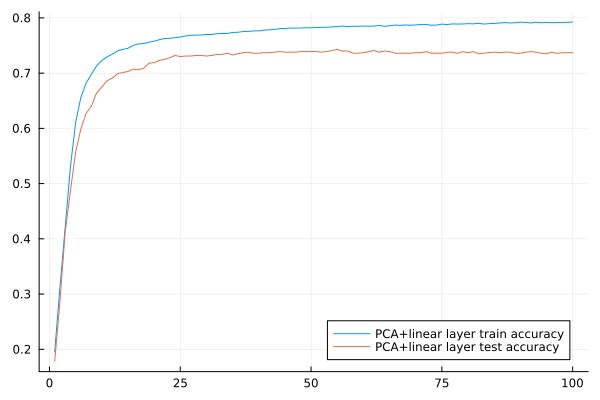

In [15]:
println("PCA+linear layer test accuracy = ", accs_test_lin[end]*100, "%")
Plots.plot(accs_train_lin, label="PCA+linear layer train accuracy")
Plots.plot!(accs_test_lin, label="PCA+linear layer test accuracy")

In [16]:
#= 

Train with the QRC embeddings

=#

loss_qrc, accs_train_qrc, accs_test_qrc = train(
    embeddings, ys, test_embeddings, test_targets; 
    regularization=0.0005, 
    nepochs=100, 
    batchsize=1000, 
    opt=Flux.Adam(0.01),
    verbose=true,
    nonlinear=false
    )

Training...


0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
3.0%┣█▍                                            ┫ 3/100 [00:00<00:08, 12it/s]
5.0%┣██▎                                           ┫ 5/100 [00:00<00:06, 15it/s]
7.0%┣███▏                                          ┫ 7/100 [00:00<00:06, 17it/s]
9.0%┣████▏                                         ┫ 9/100 [00:00<00:05, 17it/s]
10.0%┣████▍                                       ┫ 10/100 [00:01<00:05, 18it/s]
12.0%┣█████▎                                      ┫ 12/100 [00:01<00:05, 18it/s]
13.0%┣█████▊                                      ┫ 13/100 [00:01<00:05, 17it/s]
15.0%┣██████▋                                     ┫ 15/100 [00:01<00:05, 18it/s]
16.0%┣███████                                     ┫ 16/100 [00:01<00:05, 18it/s]
17.0%┣███████▌                                    ┫ 17/100 [00:01<00:05, 18it/s]
18.0%┣████████              

([1.296217441558838, 0.9173304438591003, 0.7650265693664551, 0.6934551000595093, 0.6537827253341675, 0.6289592981338501, 0.6134052872657776, 0.5976125001907349, 0.5892660021781921, 0.5804547071456909  …  0.484281986951828, 0.48729491233825684, 0.4861859977245331, 0.48372378945350647, 0.4856860339641571, 0.4832870662212372, 0.48367440700531006, 0.48266810178756714, 0.48673611879348755, 0.4884791970252991], [0.7058, 0.7443, 0.7806, 0.8, 0.8125, 0.8187, 0.8235, 0.8282, 0.8291, 0.83  …  0.8516, 0.848, 0.8494, 0.8531, 0.8536, 0.8533, 0.8523, 0.8526, 0.8506, 0.8522], [0.684, 0.718, 0.738, 0.764, 0.773, 0.793, 0.808, 0.804, 0.801, 0.809  …  0.832, 0.825, 0.829, 0.835, 0.831, 0.838, 0.834, 0.836, 0.829, 0.832])

QRC test accuracy=83.2%


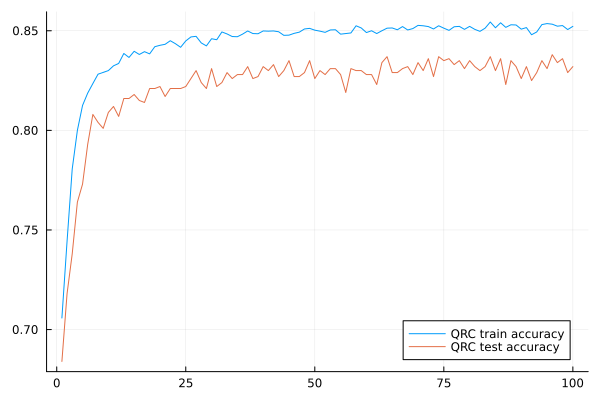

In [17]:
println("QRC test accuracy=", accs_test_qrc[end]*100, "%")
Plots.plot(accs_train_qrc, label="QRC train accuracy")
Plots.plot!(accs_test_qrc, label="QRC test accuracy")

In [18]:
#= 

Train with the PCA features on a 4-layer neural network

=#

loss_nn, accs_train_nn = train(
    xs, ys, test_features, test_targets; 
    regularization=0.0005, 
    nepochs=100, 
    batchsize=1000, 
    opt=Flux.Adam(0.01),
    verbose=true,
    nonlinear=true 
)

Training...


0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:02<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:02<04:04, 2s/it]
3.0%┣█▍                                             ┫ 3/100 [00:03<02:05, 1s/it]
4.0%┣█▉                                             ┫ 4/100 [00:03<01:25, 1it/s]
5.0%┣██▍                                            ┫ 5/100 [00:03<01:05, 1it/s]
6.0%┣██▉                                            ┫ 6/100 [00:03<00:52, 2it/s]
7.0%┣███▎                                           ┫ 7/100 [00:03<00:44, 2it/s]
8.0%┣███▊                                           ┫ 8/100 [00:03<00:38, 2it/s]
9.0%┣████▎                                          ┫ 9/100 [00:03<00:34, 3it/s]
10.0%┣████▌                                        ┫ 10/100 [00:03<00:30, 3it/s]
11.0%┣█████                                        ┫ 11/100 [00:03<00:27, 3it/s]
12.0%┣█████▍                

([0.6271454095840454, 0.5071801543235779, 0.44103339314460754, 0.40426090359687805, 0.3984569013118744, 0.38547924160957336, 0.37482669949531555, 0.371097207069397, 0.3678938150405884, 0.36923453211784363  …  0.2679975628852844, 0.2659956216812134, 0.26249927282333374, 0.27170515060424805, 0.26397016644477844, 0.26251375675201416, 0.2722599506378174, 0.26713258028030396, 0.2672305107116699, 0.2650471329689026], [0.7893, 0.8311, 0.8542, 0.8675, 0.8637, 0.8737, 0.879, 0.8814, 0.8785, 0.8799  …  0.9088, 0.912, 0.9122, 0.9078, 0.9131, 0.9132, 0.9083, 0.9103, 0.9103, 0.9093], [0.768, 0.803, 0.833, 0.84, 0.83, 0.839, 0.843, 0.848, 0.836, 0.844  …  0.854, 0.867, 0.854, 0.848, 0.854, 0.859, 0.857, 0.848, 0.861, 0.863])

In [19]:
println("PCA+NN test accuracy=", accs_test_nn[end]*100, "%")
Plots.plot(accs_train_nn, label="PCA+NN train accuracy")
Plots.plot!(accs_test_nn, label="PCA+NN test accuracy")

UndefVarError: UndefVarError: `accs_test_nn` not defined